In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from matplotlib.ticker import MaxNLocator

np.random.seed(42)

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [3]:
# Load p_values from the hit calling process
A549_p_values = pd.read_csv('../Hit_Calling/outputs/A549_significant_features_mann_whitney_p_values.csv.gz').set_index('Gene')
HeLa_DMEM_p_values = pd.read_csv('../Hit_Calling/outputs/HeLa_DMEM_significant_features_mann_whitney_p_values.csv.gz').set_index('Gene')
HeLa_HPLM_p_values = pd.read_csv('../Hit_Calling/outputs/HeLa_HPLM_significant_features_mann_whitney_p_values.csv.gz').set_index('Gene')

# Extract expression data from the Broad Institute Dependency Map
with open("../Hit_Calling/outputs/A549_CCLE_expression_summary.json") as f:
    A549_express = json.load(f)
A549_expressed_gene_list = A549_express['expressed_genes']
A549_all_genes_list= A549_express['all_genes']

with open("../Hit_Calling/outputs/HeLa_CCLE_expression_summary.json") as f:
    HeLa_express = json.load(f)
HeLa_expressed_gene_list = HeLa_express['expressed_genes']
HeLa_all_genes_list= HeLa_express['all_genes']

CCLE_expression = pd.read_csv("../Hit_Calling/inputs/CCLE_expression_HeLa_A549.csv").sort_values(by=['Gene']).set_index('Gene')
A549_express = CCLE_expression['A549']
HeLa_express = CCLE_expression['HeLa']

# Load hits from the hit calling process
A549_whole_cell_hits_list = list(pd.read_csv('../2_A549_WGS_Summary/outputs/A549_plate_level_median_per_feat_sig_genes_5_fdr_whole_cell_hits.csv')['Gene'])
A549_comp_spec_hits_list = list(pd.read_csv('../2_A549_WGS_Summary/outputs/A549_plate_level_median_per_feat_sig_genes_5_fdr_compartment_specific_hits.csv')['Gene'])
A549_hit_list = A549_comp_spec_hits_list + A549_whole_cell_hits_list

HeLa_DMEM_whole_cell_hits_list = list(pd.read_csv('../3_HeLa_WGS_Summary/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_5_fdr_whole_cell_hits.csv')['Gene'])
HeLa_DMEM_comp_spec_hits_list = list(pd.read_csv('../3_HeLa_WGS_Summary/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_5_fdr_compartment_specific_hits.csv')['Gene'])
HeLa_DMEM_hit_list = HeLa_DMEM_comp_spec_hits_list + HeLa_DMEM_whole_cell_hits_list

HeLa_HPLM_whole_cell_hits_list = list(pd.read_csv('../3_HeLa_WGS_Summary/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_5_fdr_whole_cell_hits.csv')['Gene'])
HeLa_HPLM_comp_spec_hits_list = list(pd.read_csv('../3_HeLa_WGS_Summary/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_5_fdr_compartment_specific_hits.csv')['Gene'])
HeLa_HPLM_hit_list = HeLa_HPLM_comp_spec_hits_list + HeLa_HPLM_whole_cell_hits_list

In [4]:
# Calculate the morphological signal scores for each perturbation and sort 
def morphological_signal_scores(df_p_values,expressed_gene_list):
    exp_p_values = df_p_values.loc[expressed_gene_list[:-1]]
    p_values_neg_log = -np.log10(exp_p_values)
    ranked_list = pd.DataFrame(((exp_p_values <= 0.001) * p_values_neg_log).sum(axis=1).sort_values(ascending=False))
    # Update problematic gene names
    rename_dic = {"SEPT1":"SEPTIN1","SEPT2":"SEPTIN2","SEPT3":"SEPTIN3","SEPT4":"SEPTIN4","SEPT5":"SEPTIN5",
             "SEPT6":"SEPTIN6","SEPT7":"SEPTIN7","SEPT8":"SEPTIN8","SEPT9":"SEPTIN9","SEPT10":"SEPTIN10",
             "SEPT11":"SEPTIN11","SEPT12":"SEPTIN12","SEPT14":"SEPTIN15","SEP15":"SELENOF",
             "MARCH1":"MARCHF1","MARCH2":"MARCHF2","MARCH3":"MARCHF3","MARCH4":"MARCHF4","MARCH5":"MARCHF5",
             "MARCH6":"MARCHF6","MARCH7":"MARCHF7","MARCH8":"MARCHF8","MARCH9":"MARCHF9","MARCH10":"MARCHF10",
             "MARCH11":"MARCHF11"}
    ranked_list = ranked_list.rename(index = rename_dic)
    return ranked_list

A549_ranked_list = morphological_signal_scores(A549_p_values, A549_expressed_gene_list)
HeLa_DMEM_ranked_list = morphological_signal_scores(HeLa_DMEM_p_values, HeLa_expressed_gene_list)
HeLa_HPLM_ranked_list = morphological_signal_scores(HeLa_HPLM_p_values, HeLa_expressed_gene_list)

HeLa_HPLM_ranked_list.head()


0
Gene               
ATP2A2  7208.687082
ILK     6955.854113
RAC1    6368.172435
EIF4E   6367.152512
ITGB1   6258.312566

In [5]:
def score_expression_df_maker(express,all_genes_list,ranked_list,cell_line):
    express_1 = express.reset_index().rename(columns={'Unnamed: 0':'Gene'})
    express_2 = express_1[express_1['Gene'].isin(all_genes_list)].query(f'{cell_line} > 0')
    list_expresed = list(express_2.query('Gene != "ZZZ3"').Gene)
    ranked_list_1 = ranked_list.loc[list_expresed].reset_index().rename(columns={"index":'Gene','Sum':'Score'})
    score_expression_df = ranked_list_1.merge(express_2,on='Gene').rename(columns={0:'Score',f'{cell_line}':'Expression'})
    return score_expression_df
    
A549_score_expression_df = score_expression_df_maker(A549_express, A549_all_genes_list, A549_ranked_list, 'A549')
HeLa_DMEM_score_expression_df = score_expression_df_maker(HeLa_express, HeLa_all_genes_list, HeLa_DMEM_ranked_list, 'HeLa')
HeLa_HPLM_score_expression_df = score_expression_df_maker(HeLa_express, HeLa_all_genes_list, HeLa_HPLM_ranked_list, 'HeLa')

A549_score_expression_df.head()

Gene        Score  Expression
0    A1BG  1437.231474    2.459432
1    A1CF  1131.993130    0.176323
2   A2ML1  1293.395659    0.028569
3  A4GALT  1296.516003    2.659925
4   A4GNT  1344.568723    0.263034

In [6]:
def score_expression_plotter(score_expression_df,comp_spec_hits_list,whole_cell_hits_list,data_set):
    x,y = score_expression_df.Score, score_expression_df.Expression 

    score_expression_comp_spec_df = score_expression_df[score_expression_df['Gene'].isin(comp_spec_hits_list)]
    score_expression_whole_cell_df = score_expression_df[score_expression_df['Gene'].isin(whole_cell_hits_list)]

    x_all, y_all = score_expression_comp_spec_df.Score, score_expression_comp_spec_df.Expression
    x_cell, y_cell = score_expression_whole_cell_df.Score, score_expression_whole_cell_df.Expression

    fig = plt.figure(figsize=(6,6), dpi=300)
    ax = plt.subplot(111)

    ax.xaxis.set_major_locator(MaxNLocator(8))
    ax.yaxis.set_major_locator(MaxNLocator(8))

    ax.set_xlabel('Morphological signal score', fontsize = 12)
    ax.set_ylabel('Expression (TPM)', fontsize = 12)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

    plt.scatter(x,y, color="steelblue", s=0.5, marker='1')
    plt.scatter(x_all, y_all , color="crimson", s=0.5, marker='1')
    plt.scatter(x_cell, y_cell , color="goldenrod", s=0.5, marker='1')
    plt.legend(['All perturbations','Compartment-specific hits','Whole cell hits'],fontsize= 7,markerscale=4)
    plt.axhline(y = 1,linewidth=0.5, color = 'indianred', linestyle="--")

    fig.savefig(os.path.join(output_folder,'figure_panels',f'{data_set}_morphological_score_expression_scatterplot.png'), 
                dpi=300,
                facecolor='w', 
                edgecolor='w',
                bbox_inches='tight')
    plt.show()


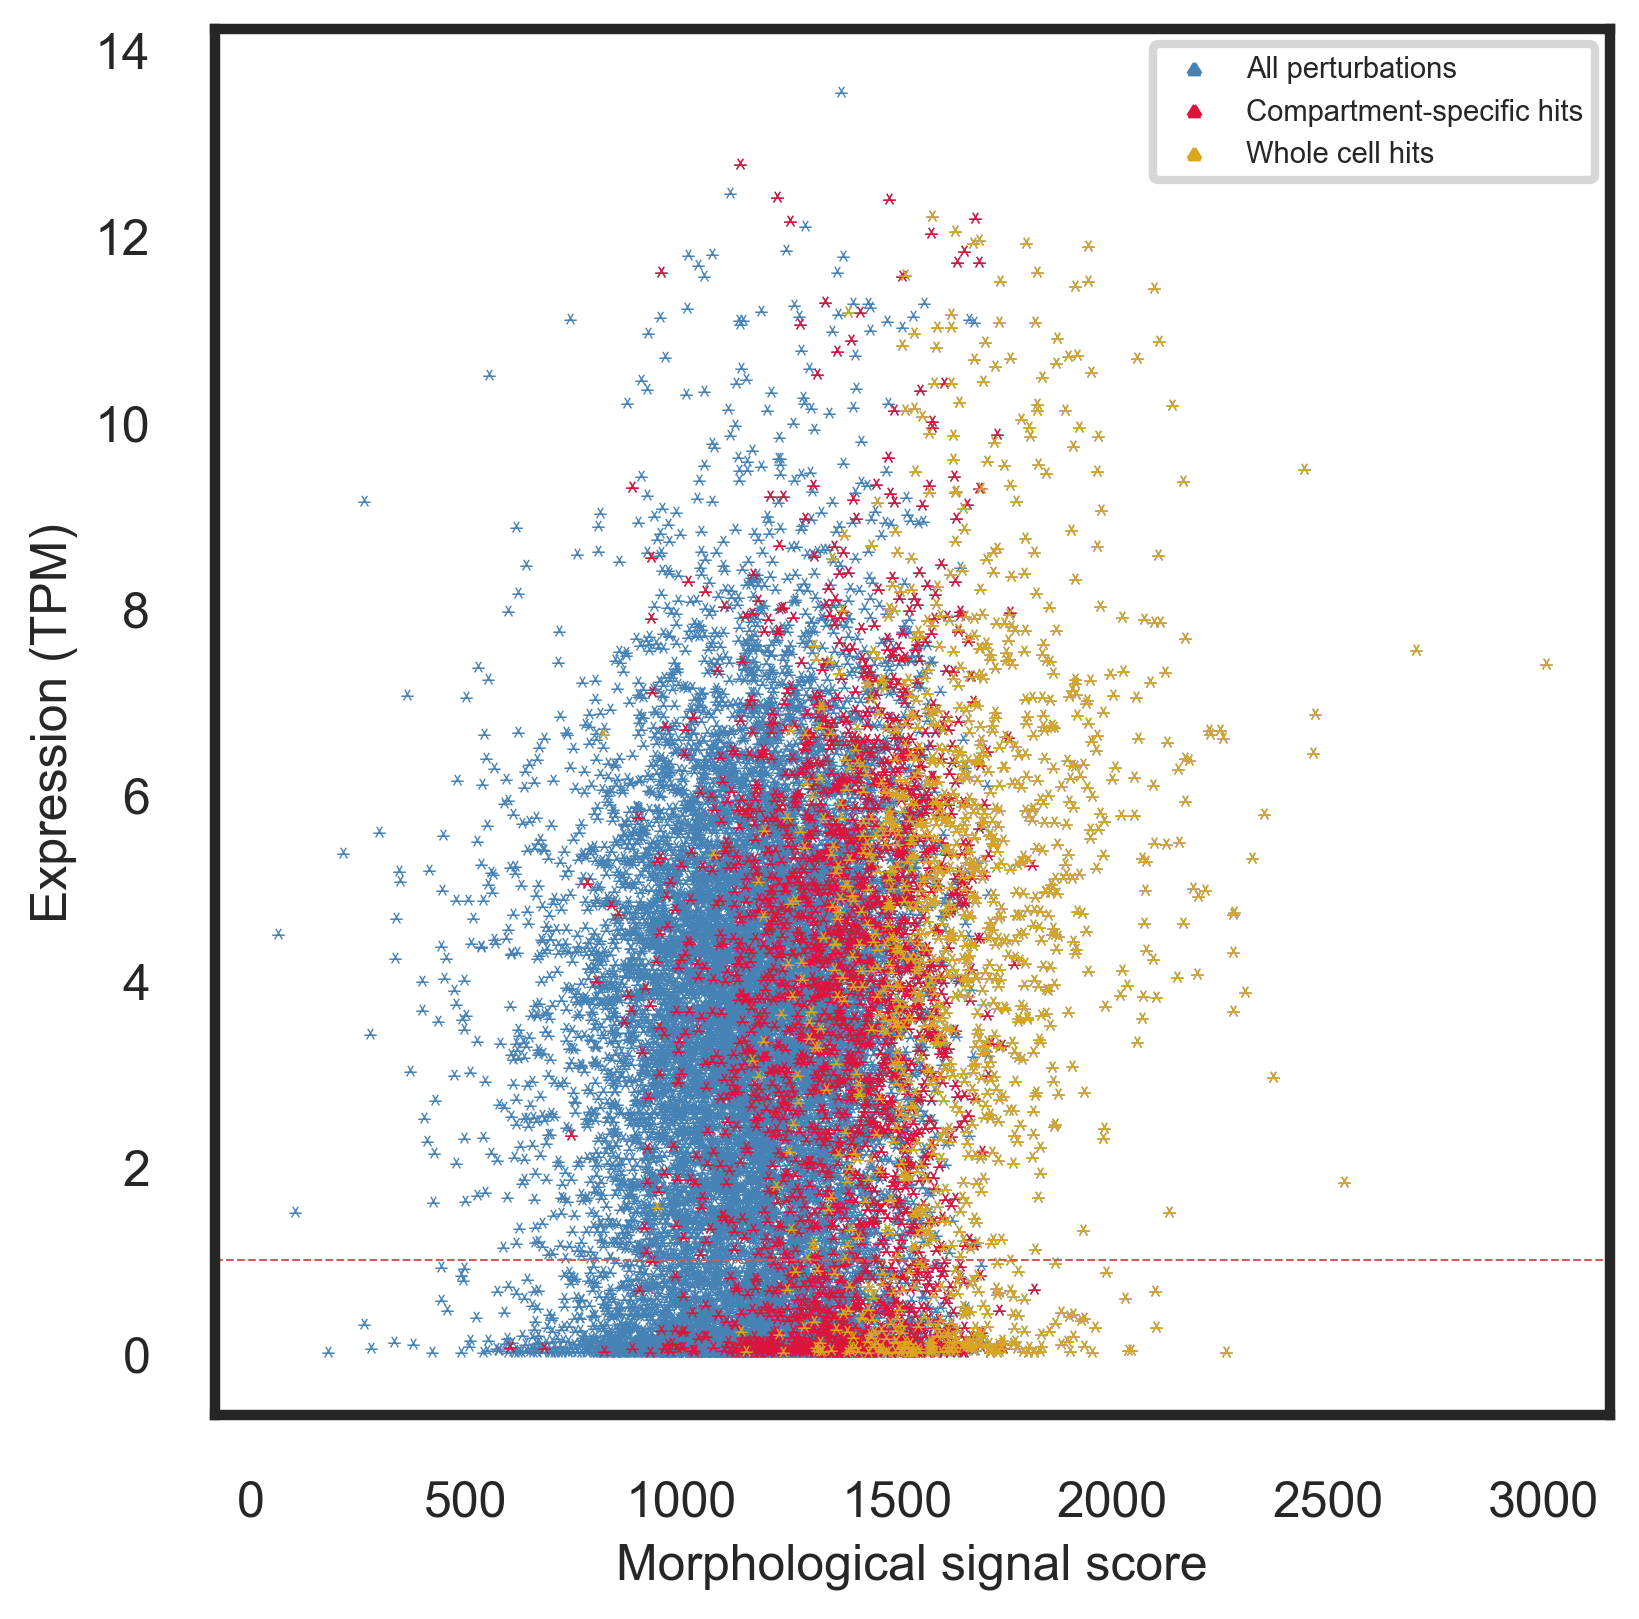

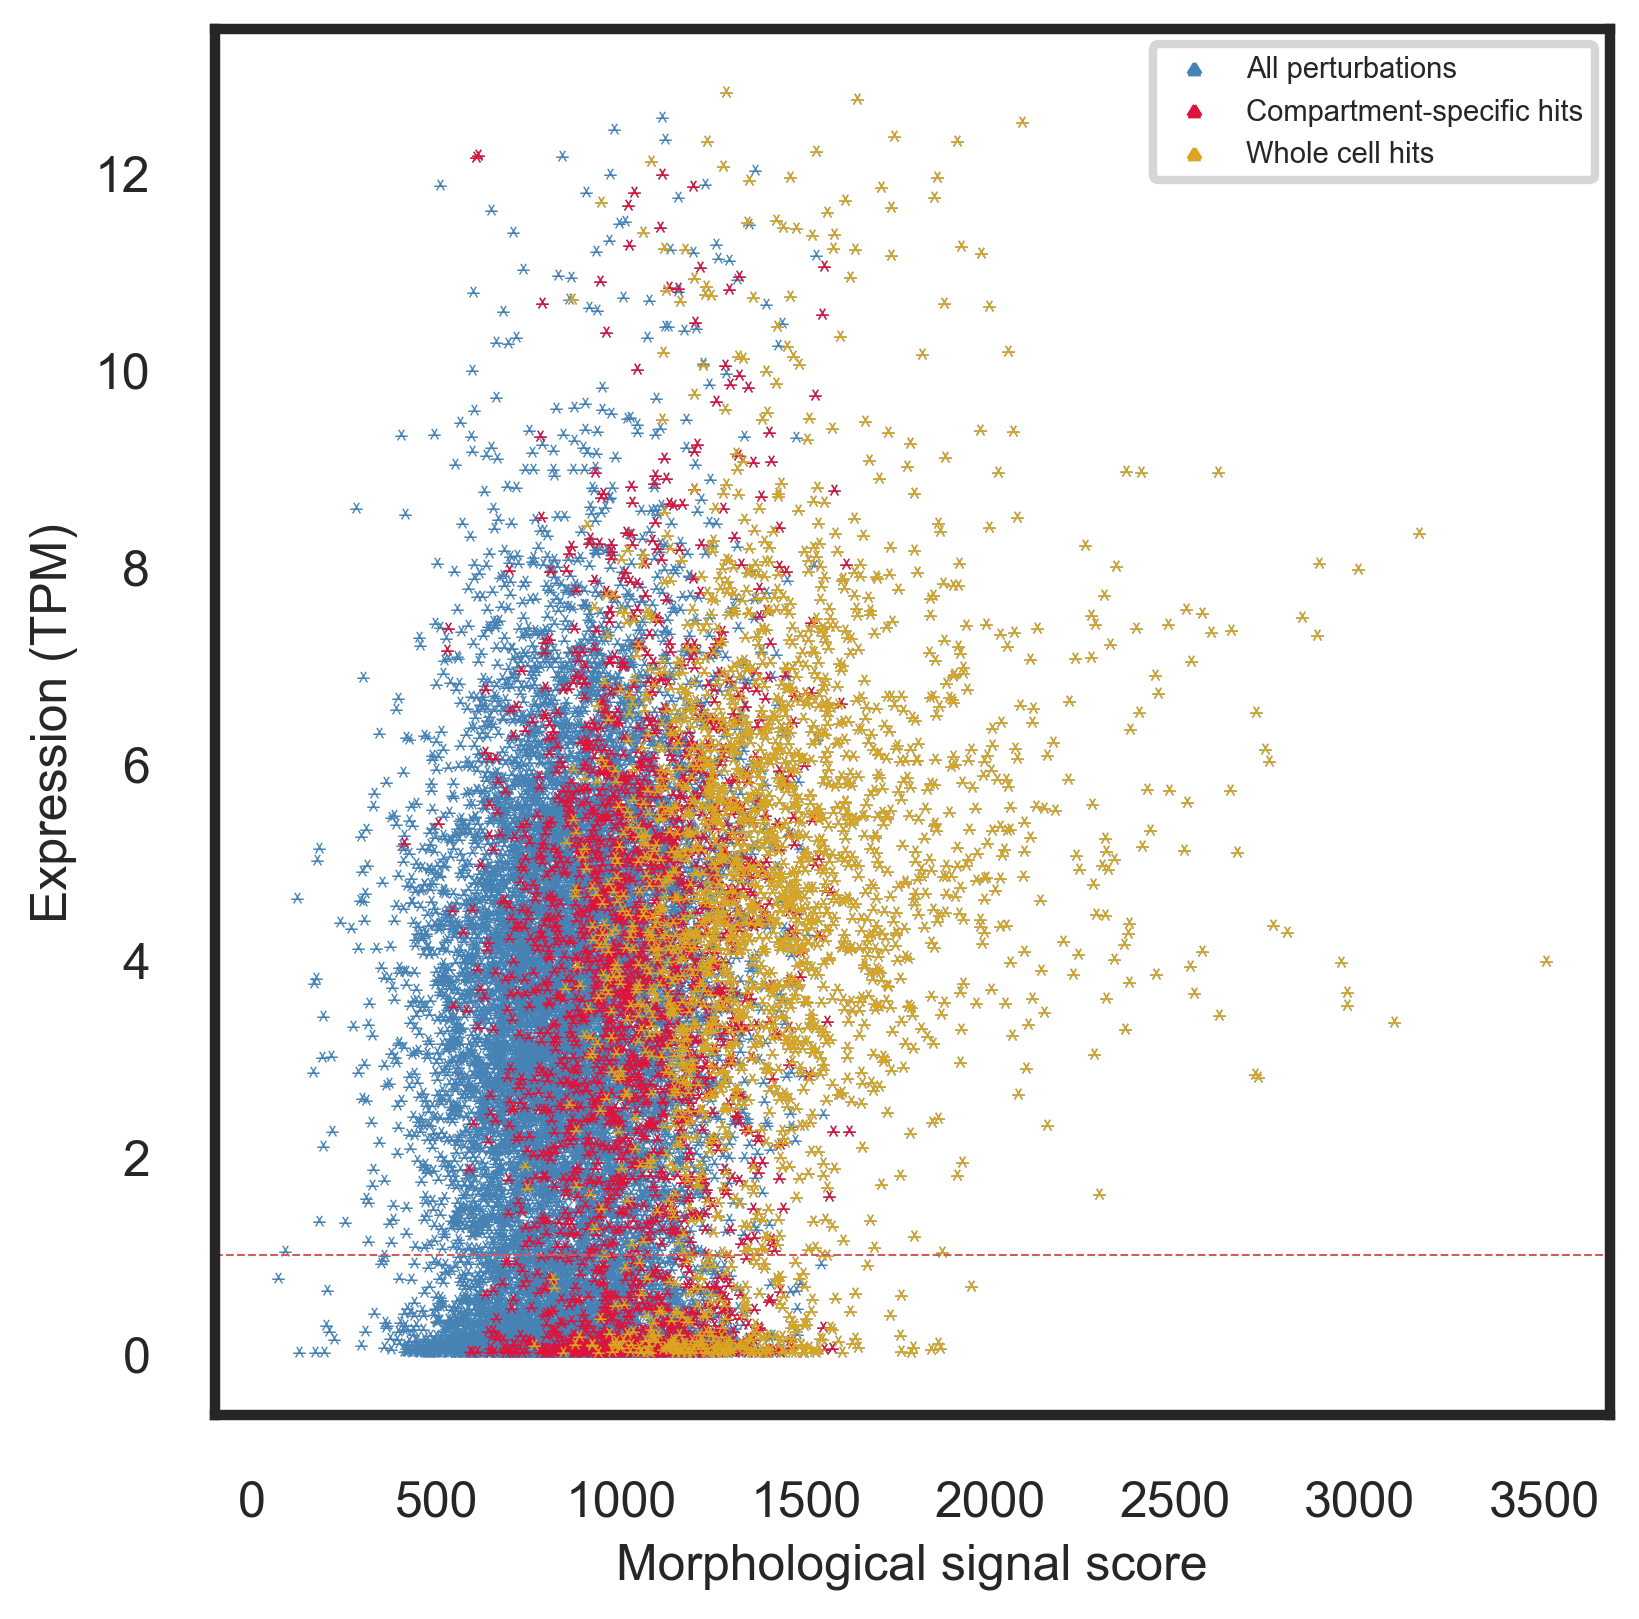

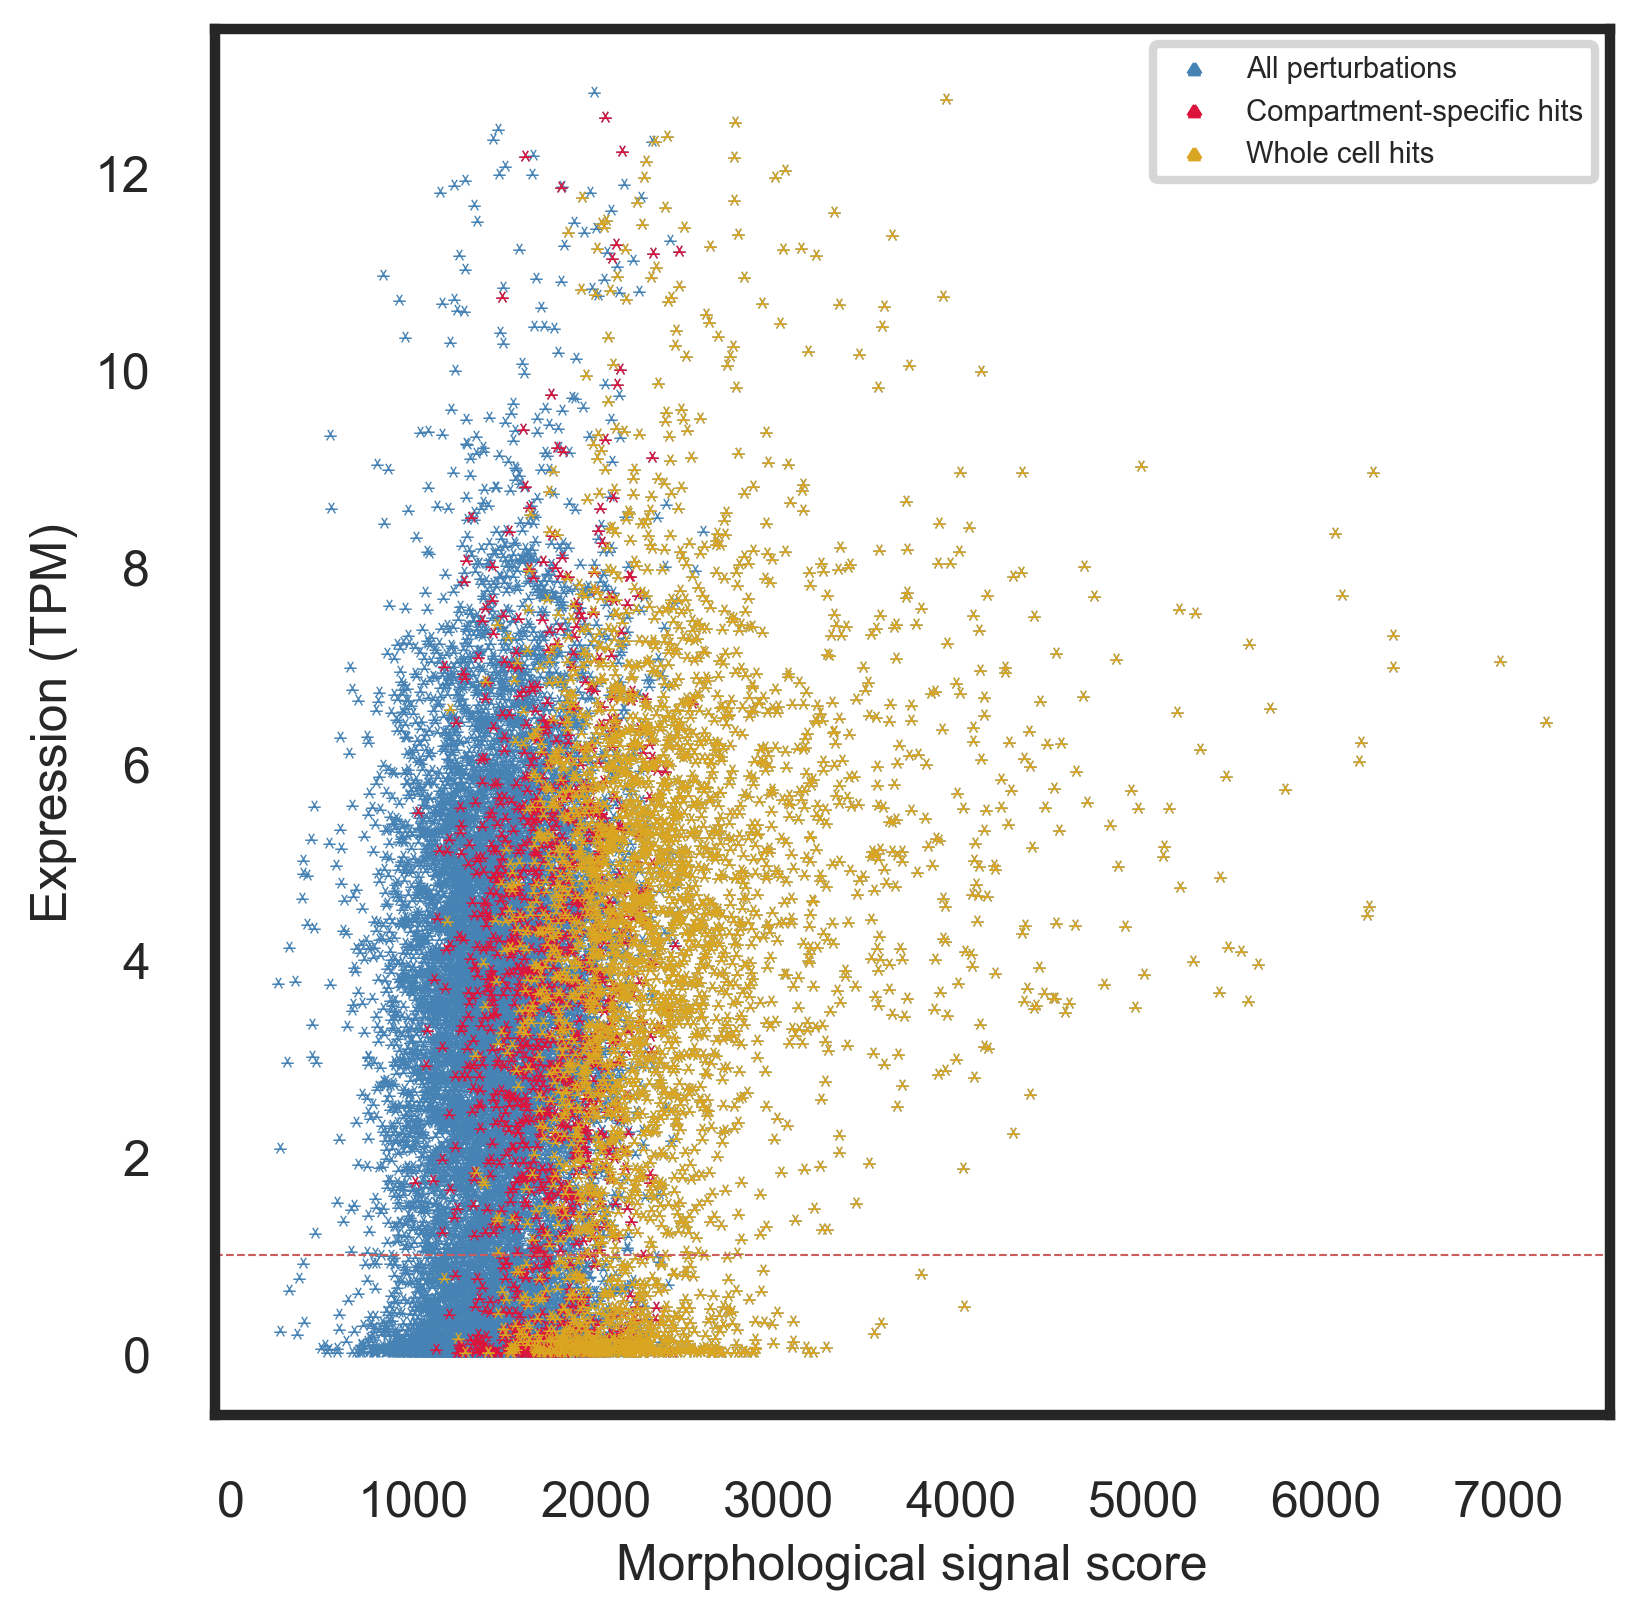

In [7]:
score_expression_plotter(A549_score_expression_df,A549_comp_spec_hits_list,A549_whole_cell_hits_list,'A549')
score_expression_plotter(HeLa_DMEM_score_expression_df,HeLa_DMEM_comp_spec_hits_list,HeLa_DMEM_whole_cell_hits_list,'HeLa_DMEM')
score_expression_plotter(HeLa_HPLM_score_expression_df,HeLa_HPLM_comp_spec_hits_list,HeLa_HPLM_whole_cell_hits_list,'HeLa_HPLM')

In [8]:
# Load the A549 CRISPR gene effect data
A549_gene_effect = pd.read_csv('../2_A549_WGS_Summary/inputs/CRISPRGeneEffect_A549.csv')
# Load the HeLa DEMETER model gene effect data
HeLa_gene_effect = pd.read_csv(os.path.join(input_folder,'D2_combined_gene_dep_scores_HeLa.csv'))

# Merge the morphological signal scores and the CRISPR gene effect data into a single dataframe
A549_effect_score_df = A549_gene_effect.merge(A549_ranked_list,on='Gene').rename(columns={0:'Score'})
A549_effect_score_df['Effect'] = pd.to_numeric(A549_effect_score_df['Effect'],errors = 'coerce')

# Merge the morphological signal scores and the CRISPR gene effect data into a single dataframe
HeLa_DMEM_effect_score_df = HeLa_gene_effect.merge(HeLa_DMEM_ranked_list,on='Gene').rename(columns={0:'Score','BayesFactor':'Effect'})
HeLa_DMEM_effect_score_df['Effect'] = pd.to_numeric(HeLa_DMEM_effect_score_df['Effect'],errors = 'coerce')

# Merge the morphological signal scores and the CRISPR gene effect data into a single dataframe
HeLa_HPLM_effect_score_df = HeLa_gene_effect.merge(HeLa_HPLM_ranked_list,on='Gene').rename(columns={0:'Score','BayesFactor':'Effect'})
HeLa_HPLM_effect_score_df['Effect'] = pd.to_numeric(HeLa_HPLM_effect_score_df['Effect'],errors = 'coerce')

In [9]:
def effect_score_plotter(effect_score_df,comp_spec_hits_list,whole_cell_hits_list,data_set):
    x,y = effect_score_df.Score , effect_score_df.Effect


    effect_score_comp_spec_df = effect_score_df[effect_score_df['Gene'].isin(comp_spec_hits_list)]
    effect_score_whole_cell_df = effect_score_df[effect_score_df['Gene'].isin(whole_cell_hits_list)]

    x_all, y_all = effect_score_comp_spec_df.Score , effect_score_comp_spec_df.Effect
    x_cell, y_cell = effect_score_whole_cell_df.Score , effect_score_whole_cell_df.Effect



    fig = plt.figure(figsize=(6,6), dpi=300)
    ax = plt.subplot(111)


    ax.xaxis.set_major_locator(MaxNLocator(8))
    ax.yaxis.set_major_locator(MaxNLocator(8))

    ax.set_xlabel('Morphological signal score', fontsize = 12)
    ax.set_ylabel('CRISPR gene effect', fontsize = 12)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
    
    plt.scatter(x,y, color="steelblue", s=0.5, marker='1')
    plt.scatter(x_all, y_all , color="crimson", s=0.5, marker='1')
    plt.scatter(x_cell, y_cell , color="goldenrod", s=0.5, marker='1')
    plt.legend(['All perturbations','Compartment-specific hits','Whole cell hits'],fontsize= 7,markerscale=4)

    plt.axhline(y = -0.5,linewidth=0.5, color = 'indianred', linestyle="--")

    fig.savefig(os.path.join(output_folder,'figure_panels',f'{data_set}_gene_effect_morphological_score.png'), 
                dpi=300,
                facecolor='w', 
                edgecolor='w',
                bbox_inches='tight')
    plt.show()


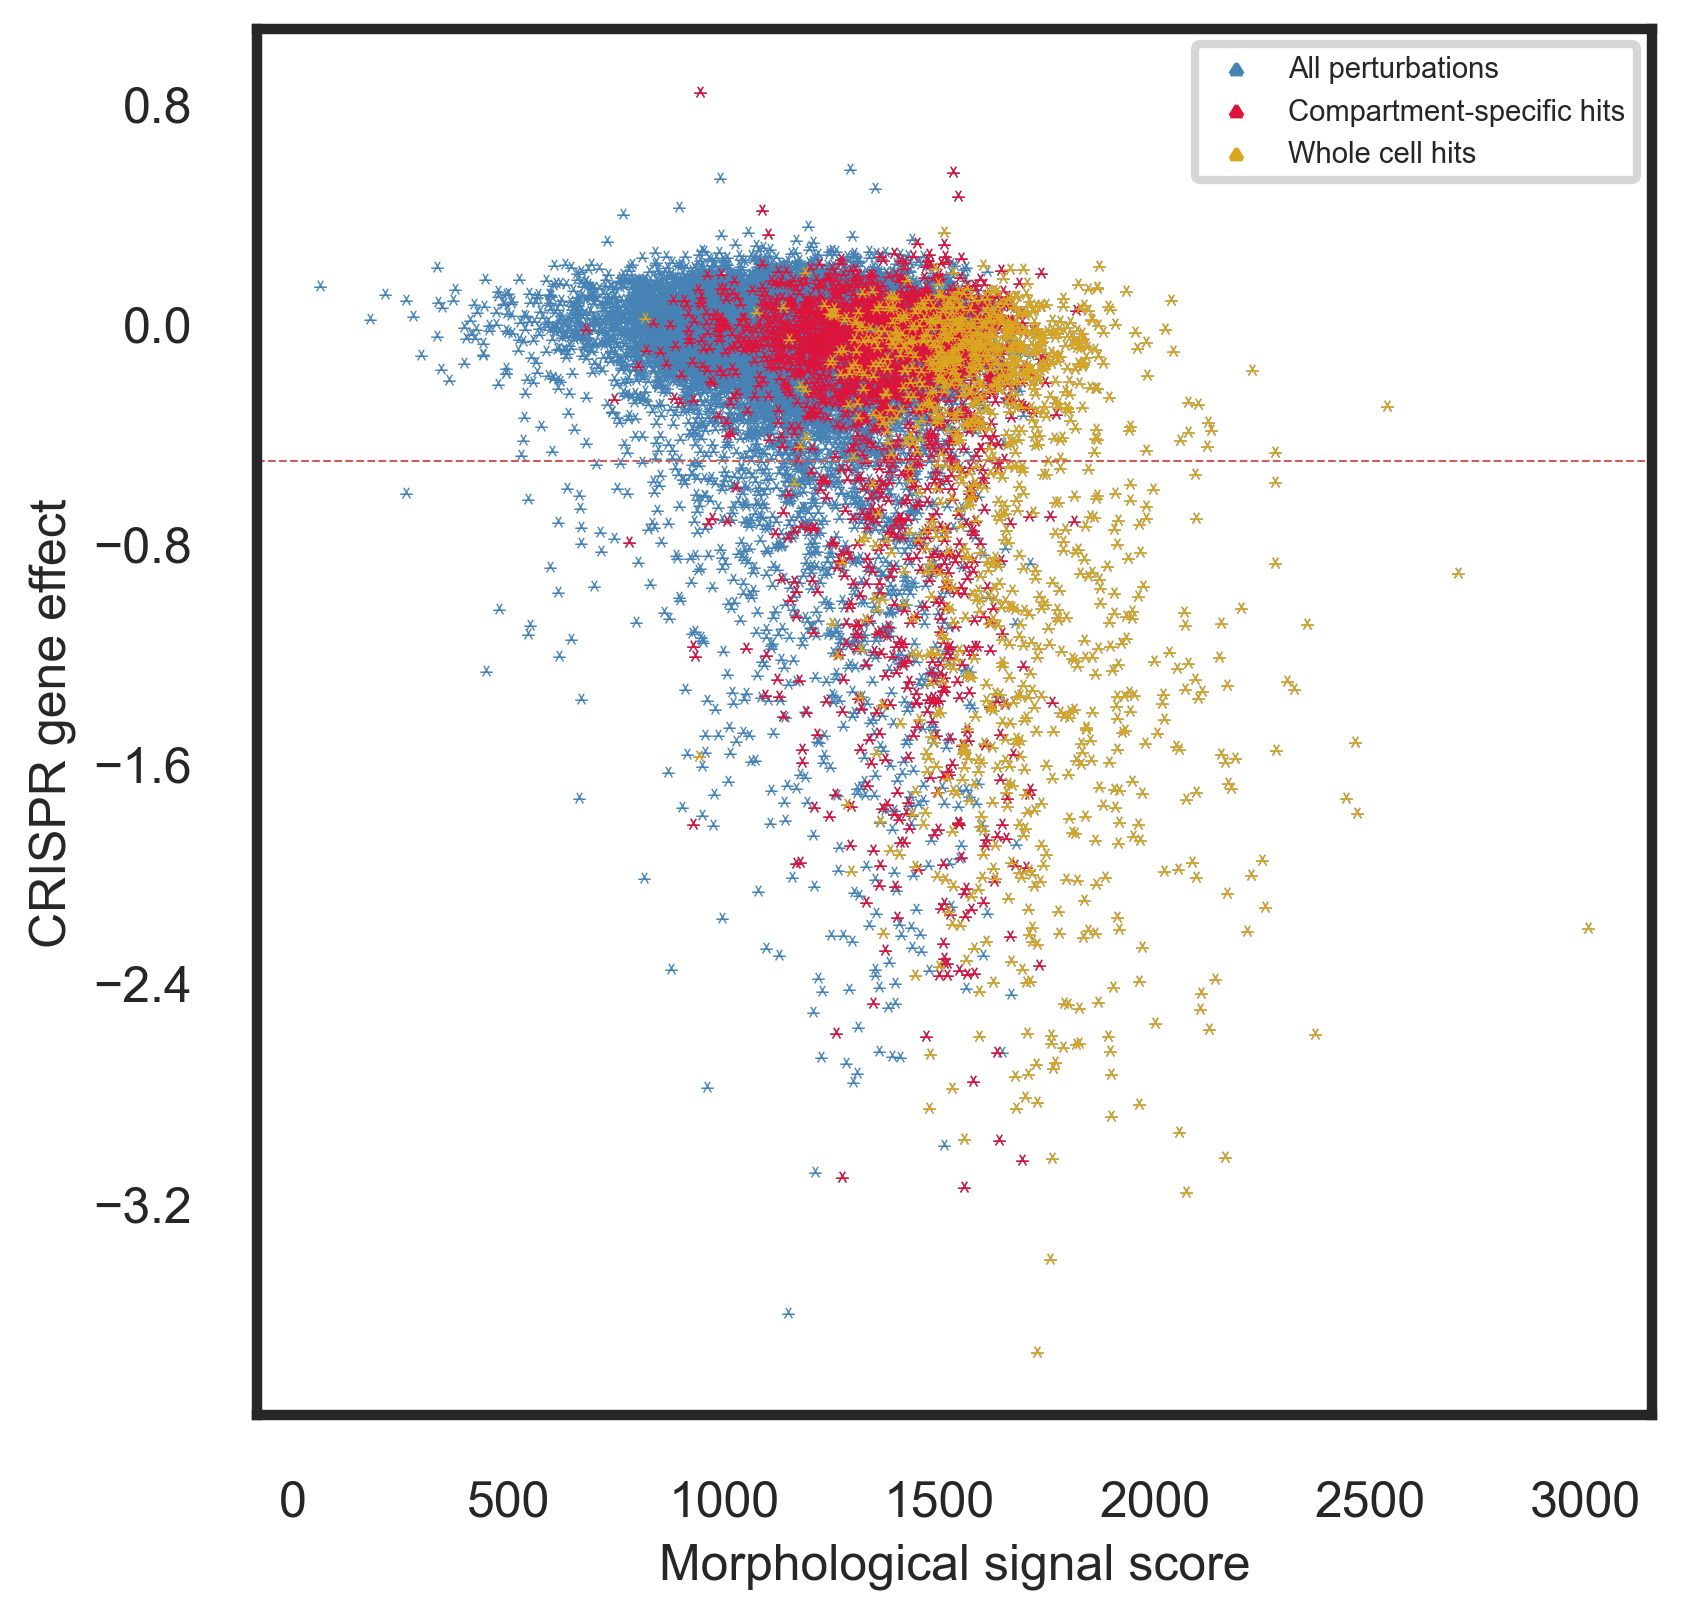

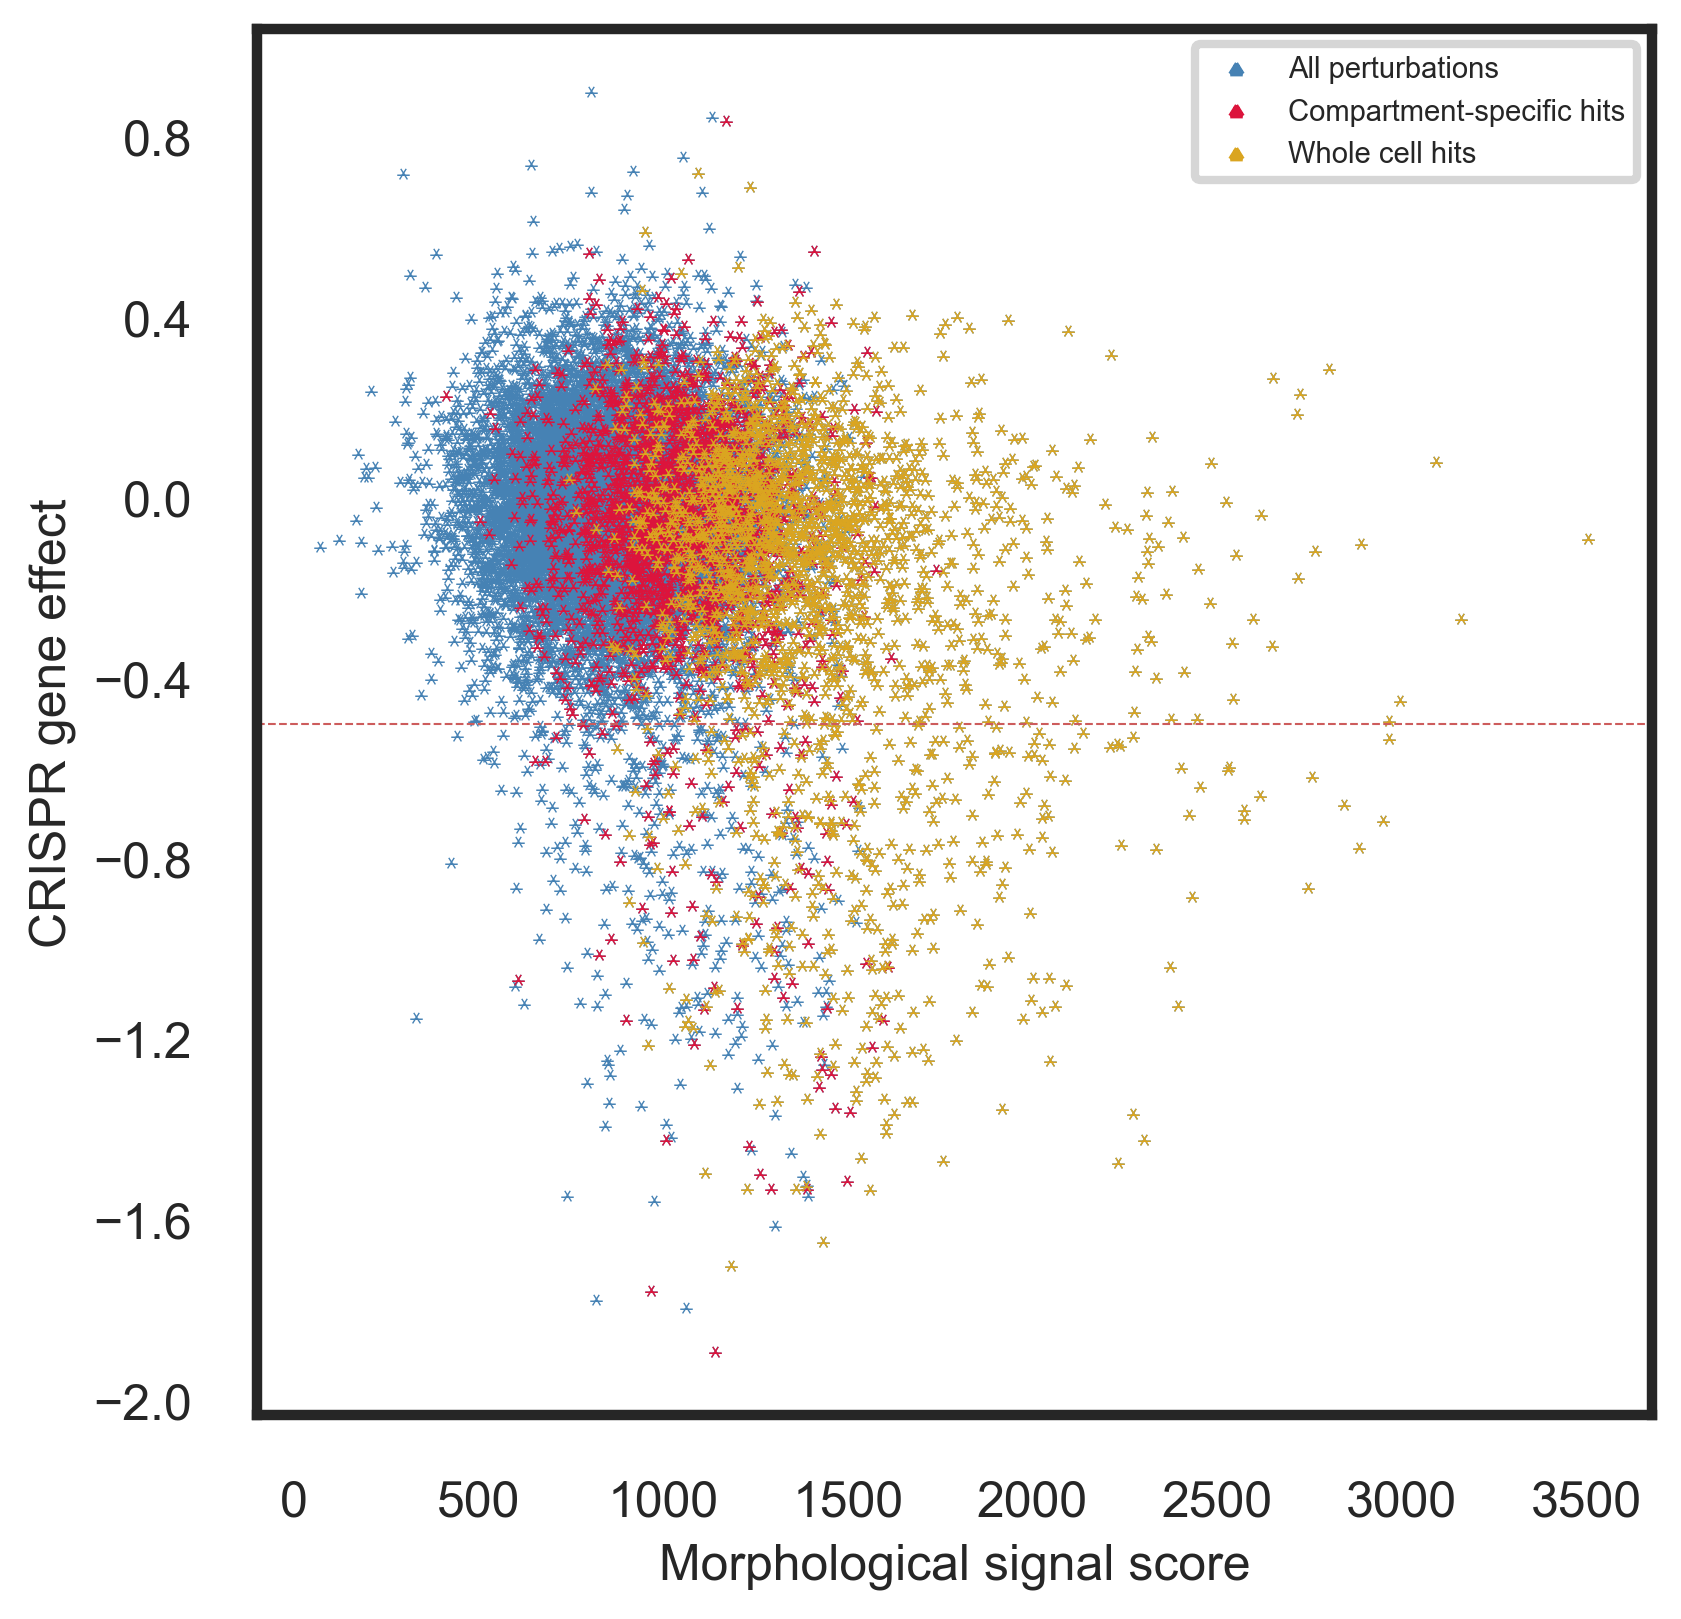

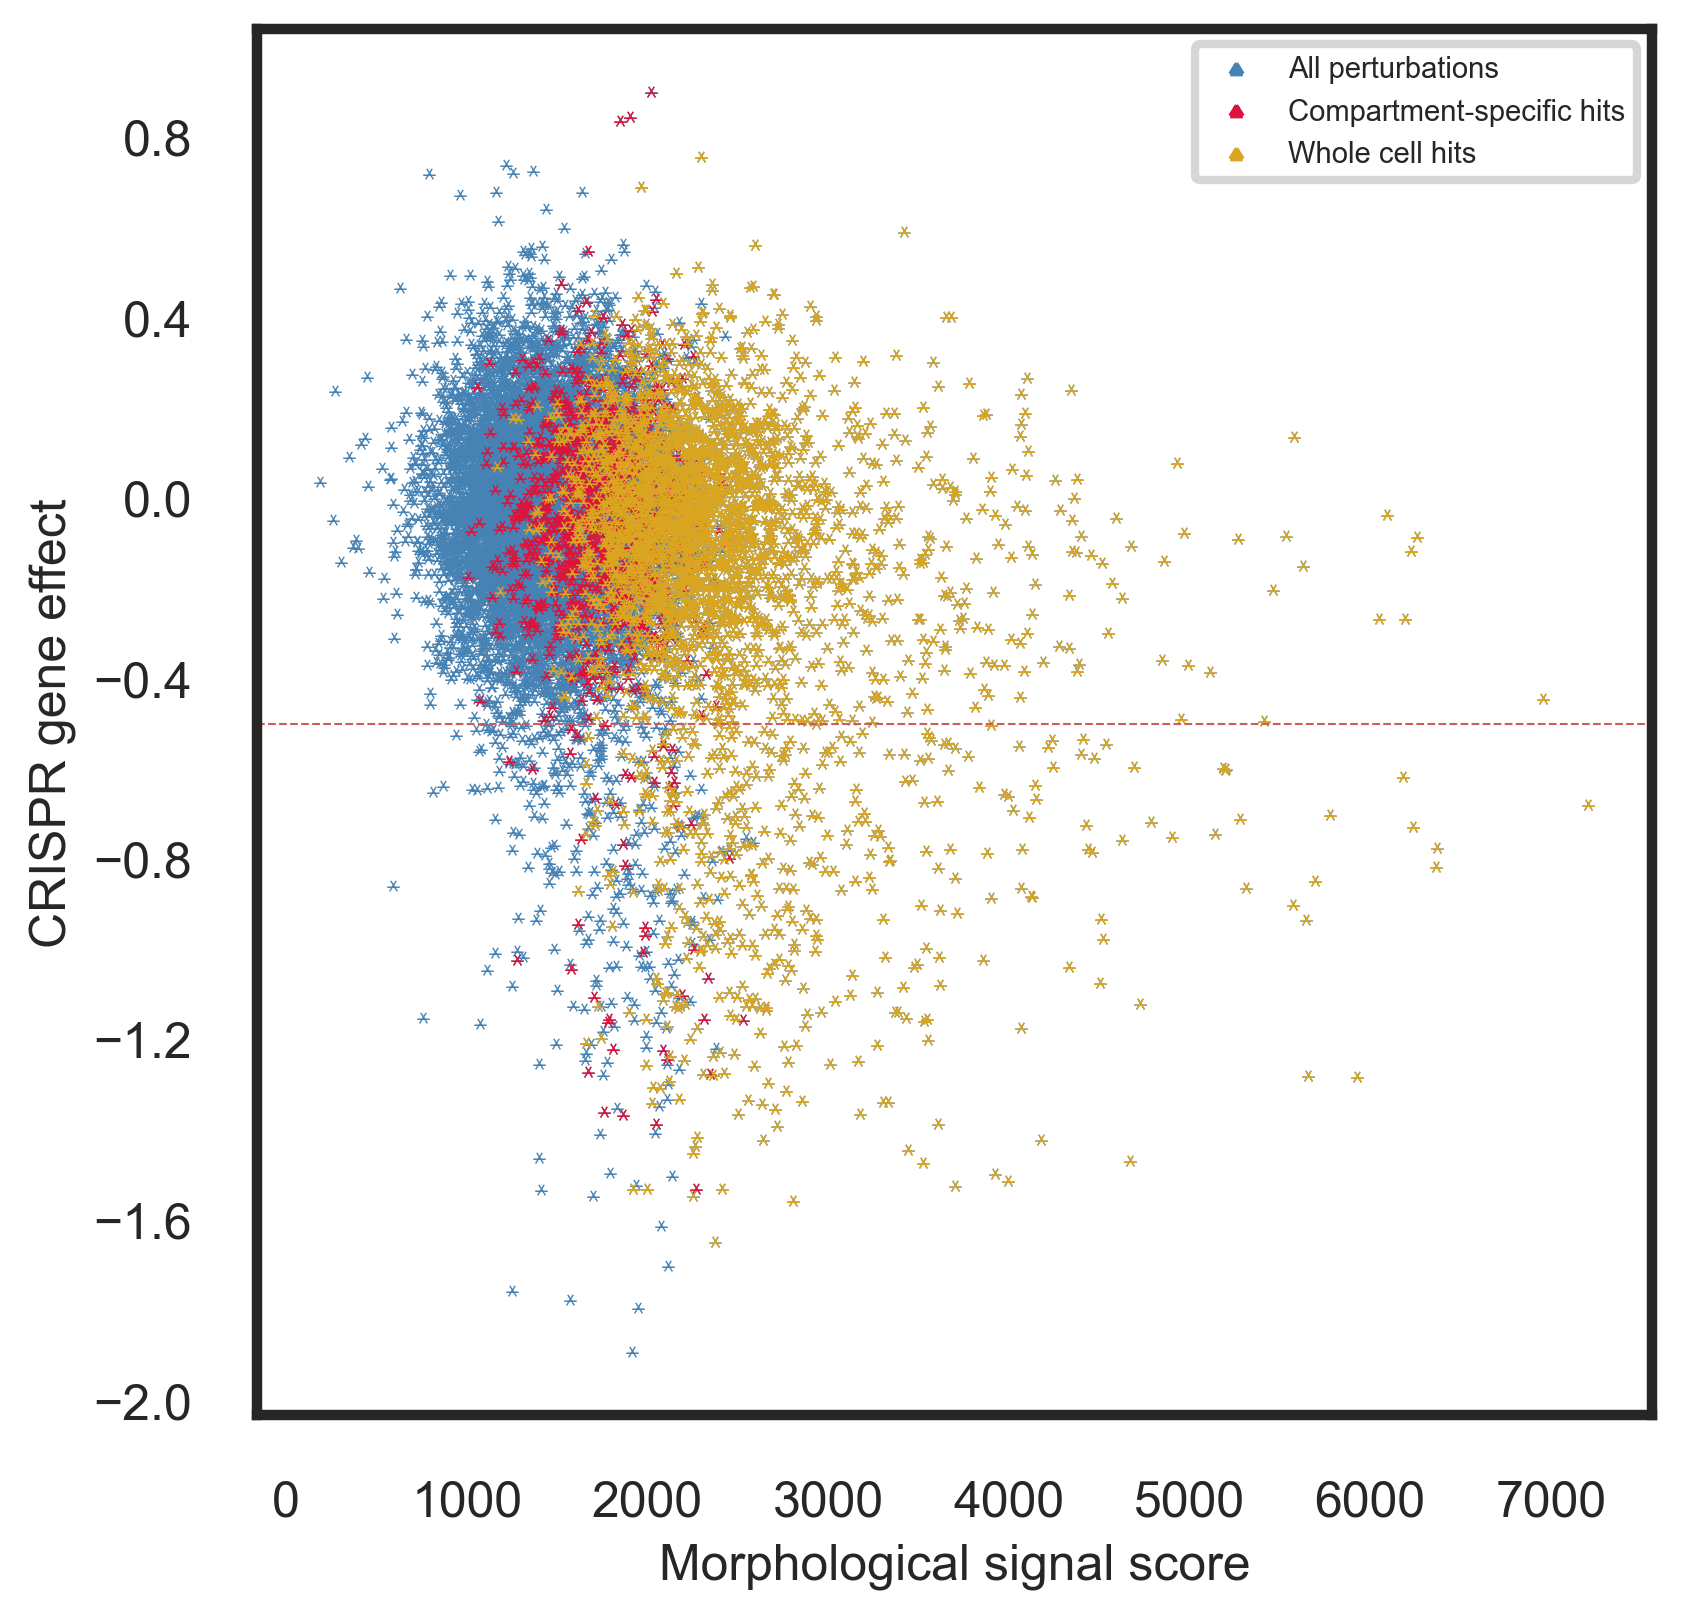

In [10]:
effect_score_plotter(A549_effect_score_df,A549_comp_spec_hits_list,A549_whole_cell_hits_list,'A549')
effect_score_plotter(HeLa_DMEM_effect_score_df,HeLa_DMEM_comp_spec_hits_list,HeLa_DMEM_whole_cell_hits_list,'HeLa_DMEM')
effect_score_plotter(HeLa_HPLM_effect_score_df,HeLa_HPLM_comp_spec_hits_list,HeLa_HPLM_whole_cell_hits_list,'HeLa_HPLM')